In [1]:

import random
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
import json
import os

from sklearn.metrics import classification_report, roc_auc_score
from scipy import interpolate
from sklearn.metrics import roc_curve, auc
from cycler import cycler
# from awkward import ak

import uproot ## means uproot4
import sklearn.metrics as m

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

In [2]:
CustNanoData = {
    'SingleMuon'   : "/data/bond/zhaoyz/Tree/V9/2016APV/Merged/SingleMuon/Tree_Data.root",
    # 'JetHT'        : "/data/pubfs/zhaoyz/Tree/V8/2016/Merged/Data/Tree_Data.root",            
    'QCD'    : "/data/bond/zhaoyz/Tree/V9/2016APV/Merged/MC/Tree_QCD.root",            
    # 'Signal' : "/data/pubfs/zhaoyz/Tree/V8/2016/Merged/Signal/Tree_Total.root",
    # 'GluGlu' : "/data/pubfs/zhaoyz/Tree/V8/2016/Merged/Signal/Tree_GluGlu.root",            
    # 'VH'     : "/data/pubfs/zhaoyz/Tree/V8/2016/Merged/Signal/Tree_VH.root",            
    # 'VBF'    : "/data/pubfs/zhaoyz/Tree/V8/2016/Merged/Signal/Tree_VBF.root",            
    # 'ttH'    : "/data/pubfs/zhaoyz/Tree/V8/2016/Merged/Signal/Tree_ttH.root",            
          
}
events = {typefile : {} for typefile in CustNanoData}
for typefile in CustNanoData:
    events[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree" }) ## lazy means lazy computation style
    # for var in ak_arrays.fields:?
    #     if "HLT" in var or "FatJet" in var:
    #         events[year][var] = ak_arrays[var]

In [3]:
MAIN_DIR = ".."

plot_dir = f"{MAIN_DIR}/plots/trigger/15Mar24"
_ = os.system(f"mkdir -p {plot_dir}")

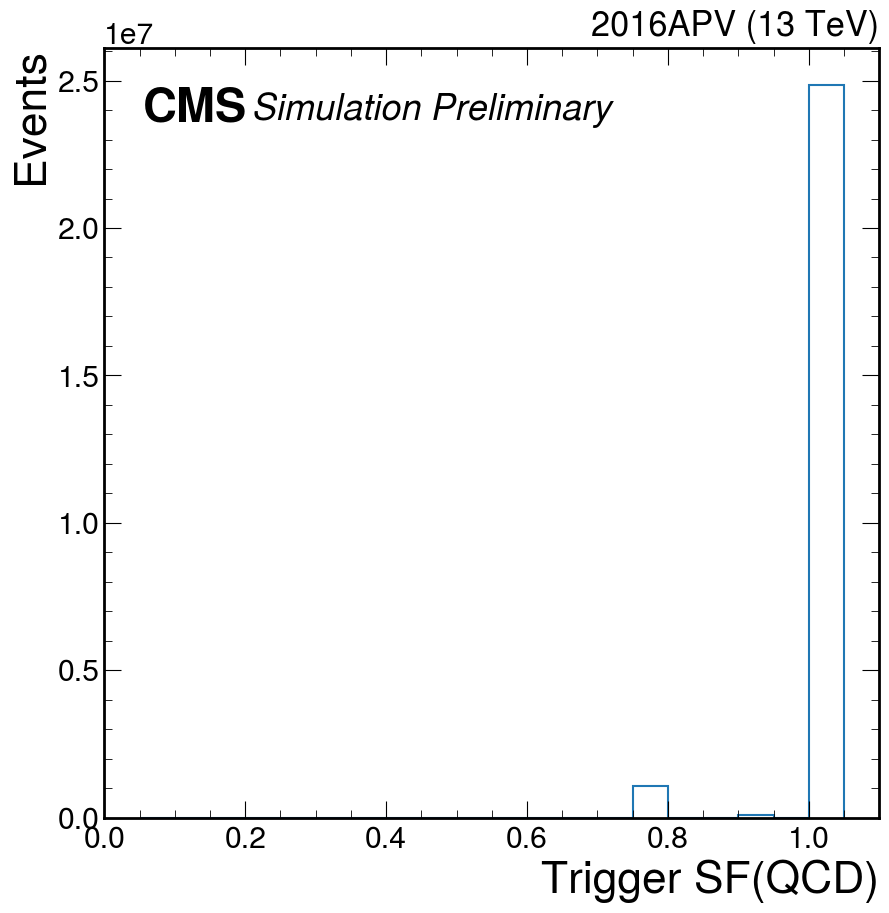

In [10]:
SFbins, SFmin, SFmax = 20, 0.05, 1.05
plt.figure(figsize=(10,10))
ax=plt.gca()
hep.cms.label(data= False, label = "Preliminary", year="2016APV", ax=ax, fontname='sans-serif', loc = 1)
hist1DSF = bh.Histogram(bh.axis.Regular(SFbins, SFmin, SFmax),storage=bh.storage.Weight())
hist1DSF.fill(events["QCD"]["TriggerSF"],weight = events["QCD"]["weight"])
h, err = hist1DSF.view().value, np.sqrt(hist1DSF.view().variance)
hep.histplot(h, bins=hist1DSF.axes[0].edges, yerr=err, histtype='step')
# plt.ylim(0, 6e7)
plt.xlabel(r"Trigger SF(QCD)", fontsize=32, ha='right', x=1)
plt.ylabel(r"Events", fontsize=32, ha='right', y = 1)
plt.savefig(f"{plot_dir}/2016APVQCDTriggerSF.pdf", bbox_inches='tight')
plt.show()

In [5]:
#Plot 2D trigger efficiency SFs unc.
def SF2DUnc_withvalue(eventsMC,eventsData, x_label, y_label, isData = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    # ax = plt.figure(figsize=(10,10))
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    # fig ,ax = plt.subplots()
    hep.cms.label(data= isData, label = "Preliminary", year="2016APV", ax=ax, fontname='sans-serif')
    mmin = 40.0
    mmax = 240.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20
    
    hist2DMC = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])

    eventsMC_Cut = eventsMC[ (eventsMC["HLT_AK8PFHT700_TrimR0p1PT0p03Mass50"] == True) | (eventsMC["HLT_PFHT650_WideJetMJJ900DEtaJJ1p5"] == True) | (eventsMC["HLT_PFHT650_WideJetMJJ950DEtaJJ1p5"] == True) | (eventsMC["HLT_PFHT800"] == True) | (eventsMC["HLT_PFHT900"] == True) | (eventsMC["HLT_PFJet450"] == True) | (eventsMC["HLT_PFJet500"] == True) | (eventsMC["HLT_AK8PFJet450"] == True) | (eventsMC["HLT_AK8PFJet500"] == True) | (eventsMC["HLT_AK8PFJet360_TrimMass30"] == True)]
    
    hist2DMC_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC_Cut.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"]* eventsMC_Cut["TriggerSF"])

    EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value



    hist2DData = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData.fill(eventsData["Mj_V2_a"],eventsData["PTj_V2_a"])

    eventsData_Cut = eventsData[ (eventsData["HLT_AK8PFHT700_TrimR0p1PT0p03Mass50"] == True) | (eventsData["HLT_PFHT650_WideJetMJJ900DEtaJJ1p5"] == True) | (eventsData["HLT_PFHT650_WideJetMJJ950DEtaJJ1p5"] == True) | (eventsData["HLT_PFHT800"] == True) | (eventsData["HLT_PFHT900"] == True) | (eventsData["HLT_PFJet450"] == True) | (eventsData["HLT_PFJet500"] == True) | (eventsData["HLT_AK8PFJet450"] == True) | (eventsData["HLT_AK8PFJet500"] == True) | (eventsData["HLT_AK8PFJet360_TrimMass30"] == True)]
    
    hist2DData_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData_Cut.fill(eventsData_Cut["Mj_V2_a"],eventsData_Cut["PTj_V2_a"])

    EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value


    Effi2DSF = EffiData2D/EffiMC2D


    #Start to calculate the uncentainty.
    Invera = 1./hist2DData_Cut.view().value
    Inverc = 1./hist2DData.view().value
    Inverb = 1./hist2DMC.view().value
    Inverd = 1./hist2DMC_Cut.view().value
    Sa = hist2DData_Cut.view().variance
    Sc = hist2DData.view().variance
    Sb = hist2DMC.view().variance
    Sd = hist2DMC_Cut.view().variance
                
    RelaUnc = np.sqrt( (Invera**2) * Sa + (Inverb**2) * Sb + (Inverc**2) * Sc + (Inverd**2) * Sd )
    Unc = Effi2DSF * RelaUnc
   
    #define mesh
    mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Unc.T , vmin = 0, vmax = 1 )
    xedges = hist2DMC.axes[0].edges
    # print(xedges)
    yedges = hist2DMC.axes[1].edges
    # print(yedges)
    h = Unc
    # print(h)
    meshed_value = []
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            print("When mass = ",xedges[i]," pT = ", yedges[j],"SF = ",h[i,j])
            if h[i,j] >= 0 and h[i,j] <= 5: 
                SFij = h[i,j] 
            else : SFij = 1
            dict_tmp = {
                "mass":xedges[i],
                "pT"  :yedges[j],
                "SF"  :SFij
                }
            meshed_value.append(dict_tmp)
            # print(h[i,j])
            plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
    with open('mesh_data_2016APV_unc.json', 'w') as json_file:
        json.dump(meshed_value, json_file)
    cbar = plt.colorbar(mesh)
    cbar.set_label('Trigger efficiency scale factor uncertainty', rotation= 90,fontsize=32)
    # plt.title('Trigger efficiency scale factor', fontsize=32,color="black", x = 0.3, y = 0.9)

    plt.xlabel(r"Higgs candidate jet $m_{SD}$", fontsize=32, ha='right', x=1)
    plt.ylabel(r"Higgs candidate $p_{T}$", fontsize=32, ha='right', y=1)
    plt.savefig(f"{plot_dir}/2016APVUnc" + y_label + "_vs_" + x_label + "TriggerEffiSF.pdf", bbox_inches='tight')

    plt.show()

/tmp/ipykernel_524902/1936031883.py:29: RuntimeWarning: invalid value encountered in divide
  EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value
/tmp/ipykernel_524902/1936031883.py:41: RuntimeWarning: invalid value encountered in divide
  EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value
/tmp/ipykernel_524902/1936031883.py:48: RuntimeWarning: divide by zero encountered in divide
  Invera = 1./hist2DData_Cut.view().value
/tmp/ipykernel_524902/1936031883.py:49: RuntimeWarning: divide by zero encountered in divide
  Inverc = 1./hist2DData.view().value
/tmp/ipykernel_524902/1936031883.py:50: RuntimeWarning: divide by zero encountered in divide
  Inverb = 1./hist2DMC.view().value
/tmp/ipykernel_524902/1936031883.py:51: RuntimeWarning: divide by zero encountered in divide
  Inverd = 1./hist2DMC_Cut.view().value
/tmp/ipykernel_524902/1936031883.py:57: RuntimeWarning: invalid value encountered in multiply
  RelaUnc = np.sqrt( (Invera**2) * Sa + (Inverb**2) * Sb + (In

When mass =  40.0  pT =  200.0 SF =  0.0651589827810697
When mass =  40.0  pT =  220.0 SF =  0.06473632844898511
When mass =  40.0  pT =  240.0 SF =  0.0665412023575845
When mass =  40.0  pT =  260.0 SF =  0.06834261783767132
When mass =  40.0  pT =  280.0 SF =  0.07180984898100033
When mass =  40.0  pT =  300.0 SF =  0.06806558830400675
When mass =  40.0  pT =  320.0 SF =  0.07108829725828499
When mass =  40.0  pT =  340.0 SF =  0.0686869392029595
When mass =  40.0  pT =  360.0 SF =  0.0665485051496875
When mass =  40.0  pT =  380.0 SF =  0.06682219619376548
When mass =  40.0  pT =  400.0 SF =  0.03718239892847217
When mass =  40.0  pT =  420.0 SF =  0.041184739424583894
When mass =  40.0  pT =  440.0 SF =  0.04470783661237708
When mass =  40.0  pT =  460.0 SF =  0.05012267142119023
When mass =  40.0  pT =  480.0 SF =  0.056318418567998275
When mass =  40.0  pT =  500.0 SF =  0.060209969662189985
When mass =  40.0  pT =  520.0 SF =  0.0702882801293325
When mass =  40.0  pT =  540.0 SF

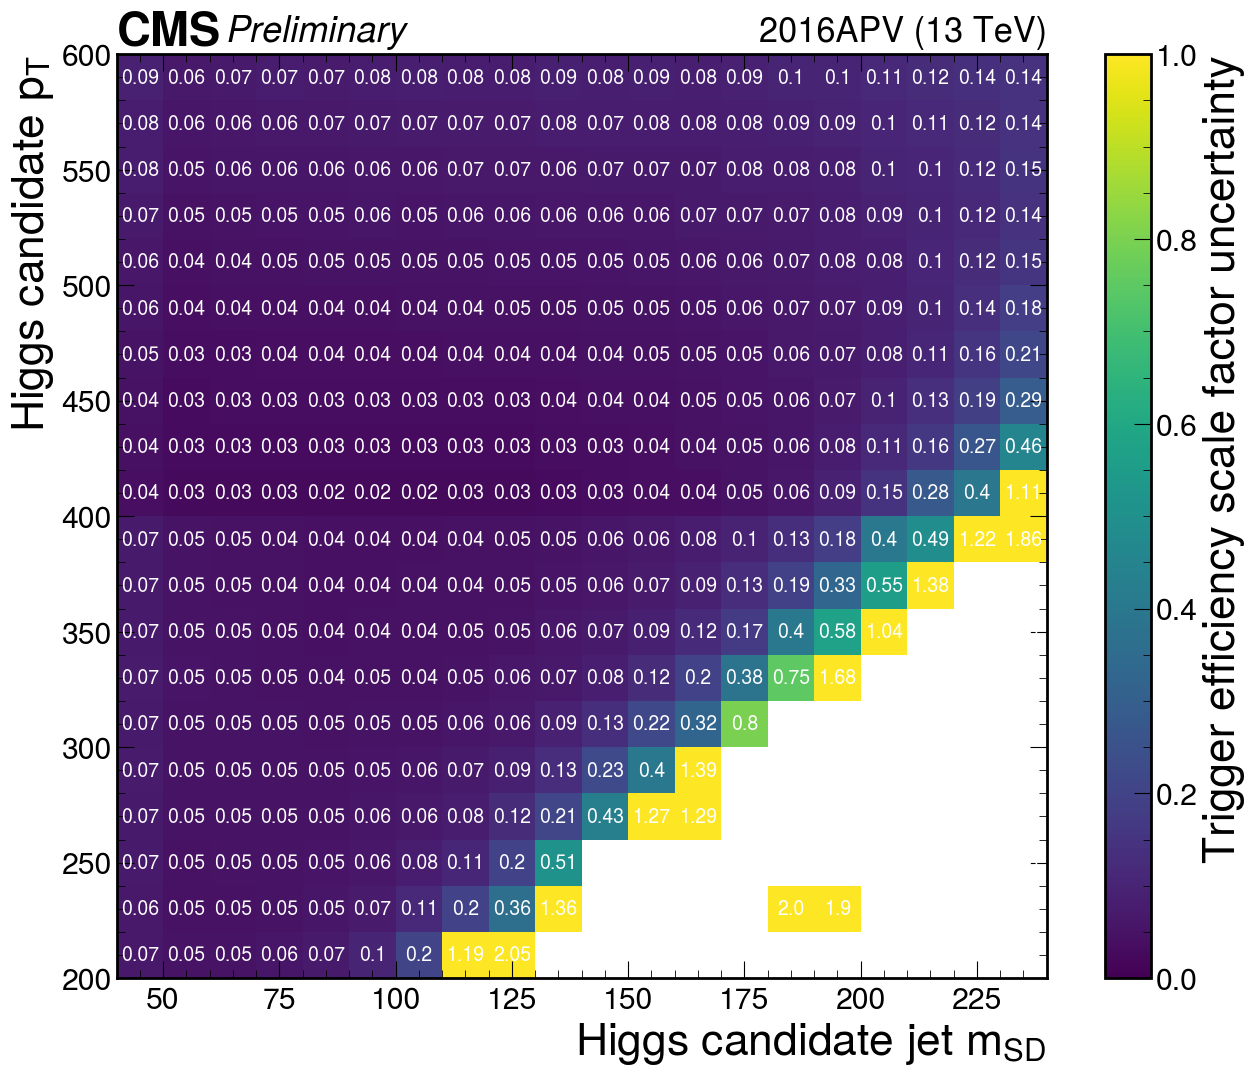

In [6]:
SF2DUnc_withvalue(eventsMC=events["QCD"], eventsData=events["SingleMuon"],x_label="Mja", y_label = "PTja",legend_location='lower right')

In [7]:
#Plot 2D trigger efficiency SFs.
def plot_effi_withvalue(eventsMC,eventsData, x_label, y_label, isData = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    # ax = plt.figure(figsize=(10,10))
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    # fig ,ax = plt.subplots()
    hep.cms.label(data= isData, label = "Preliminary", year="2016APV", ax=ax, fontname='sans-serif')
    mmin = 40.0
    mmax = 240.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20
    
    hist2DMC = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])

    eventsMC_Cut = eventsMC[ (eventsMC["HLT_AK8PFHT700_TrimR0p1PT0p03Mass50"] == True) | (eventsMC["HLT_PFHT650_WideJetMJJ900DEtaJJ1p5"] == True) | (eventsMC["HLT_PFHT650_WideJetMJJ950DEtaJJ1p5"] == True) | (eventsMC["HLT_PFHT800"] == True) | (eventsMC["HLT_PFHT900"] == True) | (eventsMC["HLT_PFJet450"] == True) | (eventsMC["HLT_PFJet500"] == True) | (eventsMC["HLT_AK8PFJet450"] == True) | (eventsMC["HLT_AK8PFJet500"] == True) | (eventsMC["HLT_AK8PFJet360_TrimMass30"] == True)]
    
    hist2DMC_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC_Cut.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"]* eventsMC_Cut["TriggerSF"])

    EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value



    hist2DData = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData.fill(eventsData["Mj_V2_a"],eventsData["PTj_V2_a"])

    eventsData_Cut = eventsData[ (eventsData["HLT_AK8PFHT700_TrimR0p1PT0p03Mass50"] == True) | (eventsData["HLT_PFHT650_WideJetMJJ900DEtaJJ1p5"] == True) | (eventsData["HLT_PFHT650_WideJetMJJ950DEtaJJ1p5"] == True) | (eventsData["HLT_PFHT800"] == True) | (eventsData["HLT_PFHT900"] == True) | (eventsData["HLT_PFJet450"] == True) | (eventsData["HLT_PFJet500"] == True) | (eventsData["HLT_AK8PFJet450"] == True) | (eventsData["HLT_AK8PFJet500"] == True) | (eventsData["HLT_AK8PFJet360_TrimMass30"] == True)]
    
    hist2DData_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData_Cut.fill(eventsData_Cut["Mj_V2_a"],eventsData_Cut["PTj_V2_a"])

    EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value


    Effi2DSF = EffiData2D/EffiMC2D

    mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Effi2DSF.T ,vmin = 0.8, vmax = 1.2)

  
    xedges = hist2DMC.axes[0].edges
    # print(xedges)
    yedges = hist2DMC.axes[1].edges
    # print(yedges)
    h = Effi2DSF
    # print(h)
    meshed_value = []
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            print("When mass = ",xedges[i]," pT = ", yedges[j],"SF = ",h[i,j])
            if h[i,j] >= 0 and h[i,j] <= 5: 
                SFij = h[i,j] 
            else : SFij = 1
            dict_tmp = {
                "mass":xedges[i],
                "pT"  :yedges[j],
                "SF"  :SFij
                }
            meshed_value.append(dict_tmp)
            # print(h[i,j])
            plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
    with open('mesh_data_2016APV.json', 'w') as json_file:
        json.dump(meshed_value, json_file)

    cbar = plt.colorbar(mesh)
    cbar.set_label('Trigger efficiency scale factor', rotation= 90,fontsize=32)
    # plt.title('Trigger efficiency scale factor', fontsize=32,color="black", x = 0.3, y = 0.9)

    plt.xlabel(r"Higgs candidate jet $m_{SD}$", fontsize=32, ha='right', x=1)
    plt.ylabel(r"Higgs candidate $p_{T}$", fontsize=32, ha='right', y=1)
    # plt.savefig("./2DSFPlots/2016Max1p5" + y_label + "_vs_" + x_label + "TriggerEffiSF.pdf", bbox_inches='tight')
    plt.savefig(f"{plot_dir}/2016APVWithValue" + y_label + "_vs_" + x_label + "TriggerEffiSF.pdf", bbox_inches='tight')
    plt.show()

/tmp/ipykernel_524902/983622766.py:29: RuntimeWarning: invalid value encountered in divide
  EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value
/tmp/ipykernel_524902/983622766.py:41: RuntimeWarning: invalid value encountered in divide
  EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value


When mass =  40.0  pT =  200.0 SF =  1.0198591786380615
When mass =  40.0  pT =  220.0 SF =  1.0145667663906712
When mass =  40.0  pT =  240.0 SF =  0.9984801540654996
When mass =  40.0  pT =  260.0 SF =  1.007362589678911
When mass =  40.0  pT =  280.0 SF =  1.0887874960056185
When mass =  40.0  pT =  300.0 SF =  1.0393999100663176
When mass =  40.0  pT =  320.0 SF =  1.0578094149203272
When mass =  40.0  pT =  340.0 SF =  1.0779996398760596
When mass =  40.0  pT =  360.0 SF =  1.0590752244963322
When mass =  40.0  pT =  380.0 SF =  1.09802665090073
When mass =  40.0  pT =  400.0 SF =  1.004901379269075
When mass =  40.0  pT =  420.0 SF =  1.0205263847111354
When mass =  40.0  pT =  440.0 SF =  1.0151799913622375
When mass =  40.0  pT =  460.0 SF =  0.994884679433713
When mass =  40.0  pT =  480.0 SF =  1.001350774473019
When mass =  40.0  pT =  500.0 SF =  0.9973302690911819
When mass =  40.0  pT =  520.0 SF =  1.0001281411770915
When mass =  40.0  pT =  540.0 SF =  1.000441340448671

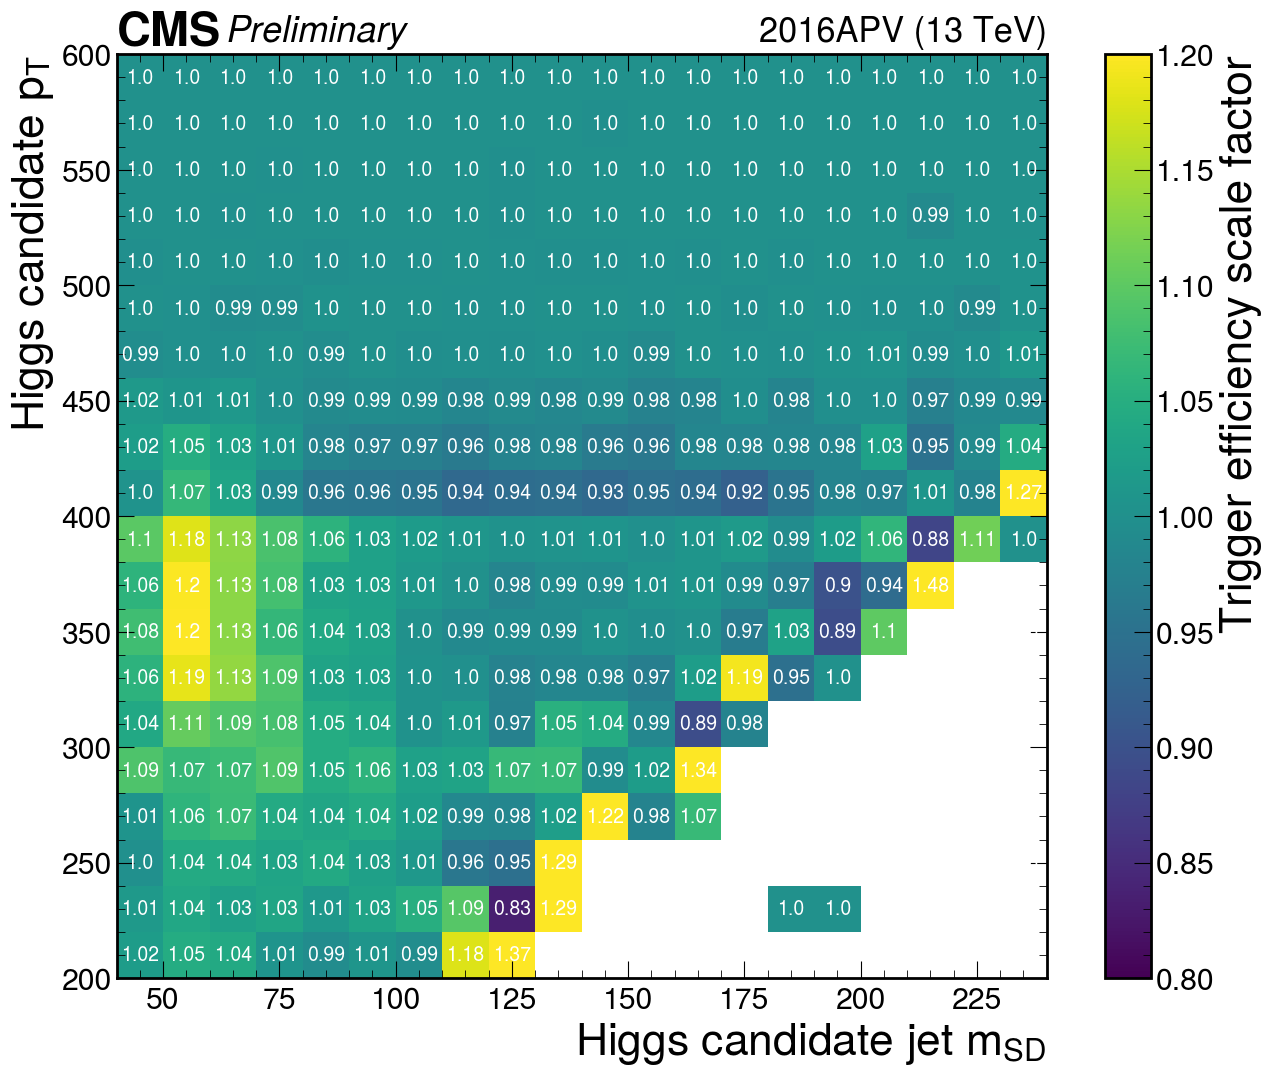

In [8]:
plot_effi_withvalue(eventsMC=events["QCD"], eventsData=events["SingleMuon"],x_label="Mja", y_label = "PTja",             xmin = 0, xmax = 300.0, bins = 300, legend_location='lower right')

In [9]:
PLACE_HOLDER

NameError: name 'PLACE_HOLDER' is not defined

### (optional) plot the 2D trigger efficiency distributionm

In [ ]:
#Plot 2D trigger efficiency SFs.
def TriggerEff2D(eventsMC, x_label, y_label, isData = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    # ax = plt.figure(figsize=(10,10))
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    # fig ,ax = plt.subplots()
    hep.cms.label(data= isData, label = "Preliminary", year="2016", ax=ax, fontname='sans-serif')
    mmin = 40.0
    mmax = 240.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20

    if isData:
        eventsData = eventsMC

        hist2DData = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DData.fill(eventsData["Mj_V2_a"],eventsData["PTj_V2_a"])

        eventsData_Cut = eventsData[ (eventsData["HLT_AK8PFHT700_TrimR0p1PT0p03Mass50"] == True) | (eventsData["HLT_PFHT650_WideJetMJJ900DEtaJJ1p5"] == True) | (eventsData["HLT_PFHT650_WideJetMJJ950DEtaJJ1p5"] == True) | (eventsData["HLT_PFHT800"] == True) | (eventsData["HLT_PFHT900"] == True) | (eventsData["HLT_PFJet450"] == True) | (eventsData["HLT_PFJet500"] == True) | (eventsData["HLT_AK8PFJet450"] == True) | (eventsData["HLT_AK8PFJet500"] == True) | (eventsData["HLT_AK8PFJet360_TrimMass30"] == True)]

        hist2DData_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DData_Cut.fill(eventsData_Cut["Mj_V2_a"],eventsData_Cut["PTj_V2_a"])

        Effi2D = hist2DData_Cut.view().value / hist2DData.view().value
        mesh = ax.pcolormesh(*hist2DData.axes.edges.T, Effi2D.T )
        
        xedges = hist2DData.axes[0].edges
        print(xedges)
        yedges = hist2DData.axes[1].edges
        print(yedges)
        h = Effi2D
        print(h)
        for i in range(len(xedges)-1):
            for j in range(len(yedges)-1):
                print(h[i,j])
                plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
        
        Namesup = "SingleMuon:"
        namestr = "./2DSFPlots_Updated_07052023/2016DataEffi2D" + y_label + "_vs_" + x_label + ".pdf"

    else:
   
        hist2DMC = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DMC.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])
    
        eventsMC_Cut = eventsMC[ (eventsMC["HLT_AK8PFHT700_TrimR0p1PT0p03Mass50"] == True) | (eventsMC["HLT_PFHT650_WideJetMJJ900DEtaJJ1p5"] == True) | (eventsMC["HLT_PFHT650_WideJetMJJ950DEtaJJ1p5"] == True) | (eventsMC["HLT_PFHT800"] == True) | (eventsMC["HLT_PFHT900"] == True) | (eventsMC["HLT_PFJet450"] == True) | (eventsMC["HLT_PFJet500"] == True) | (eventsMC["HLT_AK8PFJet450"] == True) | (eventsMC["HLT_AK8PFJet500"] == True) | (eventsMC["HLT_AK8PFJet360_TrimMass30"] == True)]
        
        hist2DMC_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DMC_Cut.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"]*eventsMC_Cut["TriggerSF"])
    
        Effi2D = hist2DMC_Cut.view().value / hist2DMC.view().value
        mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Effi2D.T )

        
        xedges = hist2DMC.axes[0].edges
        print(xedges)
        yedges = hist2DMC.axes[1].edges
        print(yedges)
        h = Effi2D
        print(h)
        
        for i in range(len(xedges)-1):
            for j in range(len(yedges)-1):
                print(h[i,j])
                plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
   

        Namesup = "QCD:"
        namestr = "./2DSFPlots_Updated_07052023/2016QCDEffi2D" + y_label + "_vs_" + x_label + ".pdf"





    # plt.title('2D-Trigger Efficiency', fontsize=32,color="black", x = 0.3, y = 0.9)
    cbar = plt.colorbar(mesh)
    cbar.set_label('Trigger efficiency', rotation= 90,fontsize=32)
    plt.xlabel(Namesup + r"Higgs candidate jet $m_{SD}$", fontsize=20, ha='right', x=1)
    plt.ylabel(Namesup + r"Higgs candidate $p_{T}$", fontsize=20, ha='right', y=1)
    plt.savefig(namestr, bbox_inches='tight')

    plt.show()

In [ ]:
TriggerEff2D(eventsMC=events["SingleMuon"],isData = True,  x_label="Mja", y_label = "PTja",legend_location='lower right')


In [ ]:
TriggerEff2D(eventsMC=events["QCD"],isData = False,  x_label="Mja", y_label = "PTja",legend_location='lower right')


In [ ]:
(0.359**2 + 0.386**2 + 0.456**2 + 0.188**2 + 0.122**2 + 0.204**2)**0.5